In [ ]:
# ## install finrl library
%%capture
!pip install git+https://github.com/Soumadip-Saha/FinRL.git


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df1 = pd.read_csv(io.BytesIO(uploaded['ind_nifty50list.csv']))
df1.head()

Saving ind_nifty50list.csv to ind_nifty50list.csv


,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
1,Asian Paints Ltd.,CONSUMER GOODS,ASIANPAINT,EQ,INE021A01026
2,Axis Bank Ltd.,FINANCIAL SERVICES,AXISBANK,EQ,INE238A01034
3,Bajaj Auto Ltd.,AUTOMOBILE,BAJAJ-AUTO,EQ,INE917I01010
4,Bajaj Finance Ltd.,FINANCIAL SERVICES,BAJFINANCE,EQ,INE296A01024


In [ ]:
new_tics = pd.unique(df1['Symbol']).tolist()
new_tics = [tics+'.NS' for tics in new_tics]
new_tics.remove('COALINDIA.NS')
new_tics.remove('HDFCLIFE.NS')
new_tics.remove('SBILIFE.NS')
print(new_tics)

['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'HDFC.NS', 'ICICIBANK.NS', 'ITC.NS', 'IOC.NS', 'INDUSINDBK.NS', 'INFY.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SHREECEM.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'UPL.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']


In [ ]:
config.START_DATE

'2009-01-01'

In [ ]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-07-06',
                     ticker_list = new_tics).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.drop(df[df.date == '2010-02-06'].index, inplace=True)
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,67.300003,68.940002,65.800003,61.530331,845745.0,ADANIPORTS.NS,4
1,2009-01-02,89.910004,90.500000,88.510002,80.486542,45390.0,ASIANPAINT.NS,4
2,2009-01-02,104.400002,109.500000,103.459999,97.598686,14261265.0,AXISBANK.NS,4
3,2009-01-02,204.699997,210.000000,199.000000,150.069885,228864.0,BAJAJ-AUTO.NS,4
4,2009-01-02,148.843155,155.229156,143.439606,152.513443,25548.0,BAJAJFINSV.NS,4


In [7]:
!rm -rf my_data
!mkdir my_data
df.tic.value_counts()

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=False,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Data clean finished!


In [ ]:
processed.head()

,date,open,high,low,close,volume,tic
0,2009-01-02,67.300003,68.940002,65.800003,61.530331,845745.0,ADANIPORTS.NS
1,2009-01-05,67.059998,79.000000,66.599998,72.517578,7391260.0,ADANIPORTS.NS
2,2009-01-06,79.400002,81.779999,76.050003,73.409164,6701300.0,ADANIPORTS.NS
3,2009-01-07,80.000000,81.379997,69.419998,65.393974,3134815.0,ADANIPORTS.NS
4,2009-01-09,69.129997,72.800003,63.610001,62.784161,1145965.0,ADANIPORTS.NS


In [ ]:
for tic in new_tics:
  df_new = df[df.tic == tic]
  df_new.sort_values(['date'], ignore_index = True)
  df_new.reset_index(drop = True, inplace = True)
  df_new.rename(columns={"tic":"symbol"}, inplace = True)
  df_new.drop("day", axis = 1, inplace = True)
  path = "my_data/"+tic[:-3]+".csv"
  df_new.to_csv(path, index = False)
  df_new.head()

In [ ]:
!zip -r /content/my_data/file.zip /content/my_data
from google.colab import files
files.download("/content/my_data/file.zip")

  adding: content/my_data/ (stored 0%)
  adding: content/my_data/BAJAJ-AUTO.csv (deflated 73%)
  adding: content/my_data/IOC.csv (deflated 72%)
  adding: content/my_data/RELIANCE.csv (deflated 71%)
  adding: content/my_data/ONGC.csv (deflated 74%)
  adding: content/my_data/POWERGRID.csv (deflated 77%)
  adding: content/my_data/HEROMOTOCO.csv (deflated 73%)
  adding: content/my_data/TITAN.csv (deflated 73%)
  adding: content/my_data/M&M.csv (deflated 72%)
  adding: content/my_data/ASIANPAINT.csv (deflated 74%)
  adding: content/my_data/BAJAJFINSV.csv (deflated 72%)
  adding: content/my_data/TATACONSUM.csv (deflated 75%)
  adding: content/my_data/NTPC.csv (deflated 74%)
  adding: content/my_data/AXISBANK.csv (deflated 74%)
  adding: content/my_data/HDFC.csv (deflated 76%)
  adding: content/my_data/ICICIBANK.csv (deflated 75%)
  adding: content/my_data/BPCL.csv (deflated 73%)
  adding: content/my_data/HDFCBANK.csv (deflated 73%)
  adding: content/my_data/SUNPHARMA.csv (deflated 73%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import sys, site
from pathlib import Path
try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    # reload
    site.main()
scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests
    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py") as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)
    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/dump_bin.py") as resp:
        with open(scripts_dir.joinpath("dump_bin.py"), "wb") as fp:
            fp.write(resp.content)

In [6]:
!python  ~/tmp/qlib_code/scripts/dump_bin.py dump_all --csv_path  /content/my_data --qlib_dir ~/kqlib/qlib_data/my_data --include_fields open,close,high,low,volume

2021-12-28 12:35:50.952 | INFO     | __main__:_get_all_date:266 - start get all date......
100% 47/47 [00:00<00:00, 78.80it/s]
2021-12-28 12:35:51.551 | INFO     | __main__:_get_all_date:285 - end of get all date.

2021-12-28 12:35:51.551 | INFO     | __main__:_dump_calendars:288 - start dump calendars......
2021-12-28 12:35:51.568 | INFO     | __main__:_dump_calendars:291 - end of calendars dump.

2021-12-28 12:35:51.568 | INFO     | __main__:_dump_instruments:294 - start dump instruments......
2021-12-28 12:35:51.569 | INFO     | __main__:_dump_instruments:296 - end of instruments dump.

2021-12-28 12:35:51.569 | INFO     | __main__:_dump_features:299 - start dump features......
100% 47/47 [00:00<00:00, 107.16it/s]
2021-12-28 12:35:52.008 | INFO     | __main__:_dump_features:306 - end of features dump.



In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,67.300003,68.940002,65.800003,61.530334,845745.0,ADANIPORTS.NS,4
1,2009-01-02,89.910004,90.500000,88.510002,80.486557,45390.0,ASIANPAINT.NS,4
2,2009-01-02,104.400002,109.500000,103.459999,97.598671,14261265.0,AXISBANK.NS,4
3,2009-01-02,204.699997,210.000000,199.000000,150.069916,228864.0,BAJAJ-AUTO.NS,4
4,2009-01-02,148.843155,155.229156,143.439606,152.513382,25548.0,BAJAJFINSV.NS,4


In [ ]:
len(df.tic.unique())
df_new.to_csv("acs")

In [ ]:
df.tic.value_counts()

HCLTECH.NS       3082
TATAMOTORS.NS    3081
M&M.NS           3081
INFY.NS          3081
SHREECEM.NS      3081
BAJAJ-AUTO.NS    3081
LT.NS            3081
TCS.NS           3081
ULTRACEMCO.NS    3081
ASIANPAINT.NS    3081
MARUTI.NS        3081
DRREDDY.NS       3081
HEROMOTOCO.NS    3081
NTPC.NS          3081
SUNPHARMA.NS     3081
ICICIBANK.NS     3081
BHARTIARTL.NS    3081
HDFCBANK.NS      3081
HINDUNILVR.NS    3081
POWERGRID.NS     3081
JSWSTEEL.NS      3081
KOTAKBANK.NS     3081
EICHERMOT.NS     3081
RELIANCE.NS      3081
AXISBANK.NS      3081
NESTLEIND.NS     3081
TITAN.NS         3081
TATASTEEL.NS     3081
DIVISLAB.NS      3081
CIPLA.NS         3081
ONGC.NS          3081
UPL.NS           3081
ADANIPORTS.NS    3081
BRITANNIA.NS     3081
INDUSINDBK.NS    3081
ITC.NS           3081
SBIN.NS          3081
BAJFINANCE.NS    3081
BAJAJFINSV.NS    3081
WIPRO.NS         3081
IOC.NS           3081
TECHM.NS         3081
GRASIM.NS        3081
TATACONSUM.NS    3081
BPCL.NS          3081
HINDALCO.N

In [ ]:
tech_indicators = ['macd',
 'rsi_30',
 'cci_30',
 'dx_30',
 'trix']

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Data clean finished!
Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,trix,turbulence
0,2009-01-02,67.300003,68.940002,65.800003,61.530334,845745.0,ADANIPORTS.NS,0.0,100.0,66.666667,100.0,2.837894,0.0
1,2009-01-02,89.910004,90.500000,88.510002,80.486557,45390.0,ASIANPAINT.NS,0.0,100.0,66.666667,100.0,2.837894,0.0
2,2009-01-02,104.400002,109.500000,103.459999,97.598671,14261265.0,AXISBANK.NS,0.0,100.0,66.666667,100.0,2.837894,0.0
3,2009-01-02,204.699997,210.000000,199.000000,150.069916,228864.0,BAJAJ-AUTO.NS,0.0,100.0,66.666667,100.0,2.837894,0.0
4,2009-01-02,148.843155,155.229156,143.439606,152.513382,25548.0,BAJAJFINSV.NS,0.0,100.0,66.666667,100.0,2.837894,0.0


In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 50, State Space: 351


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-01-01'
train_end = '2020-04-01'
val_test_start = '2020-04-01'
val_test_end = '2021-07-20'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  268.5274476205269
======Model training from:  2009-01-01 to  2020-04-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
-------------------------------------
| time/                 |           |
|    fps                | 39        |
|    iterations         | 100       |
|    time_elapsed       | 12        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -70.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 99        |
|    policy_loss        | 4.76e+03  |
|    reward             | -48.43725 |
|    std                | 0.996     |
|    value_loss         | 5.91e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 44  

ValueError: ignored

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2020-04-03,2020-07-08,PPO,0.588407,0.603625,0.60178
1,189,2020-07-08,2020-10-06,DDPG,0.441368,0.18647,0.442664
2,252,2020-10-06,2021-01-06,A2C,0.705971,0.491703,0.398184


In [ ]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  2.137395840860264


In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-07-08,NaN,2020-07-08
1,1.014732e+06,2020-07-09,0.014732,2020-07-09
2,1.015872e+06,2020-07-10,0.001123,2020-07-10
3,1.031681e+06,2020-07-13,0.015562,2020-07-13
4,1.022293e+06,2020-07-14,-0.009100,2020-07-14


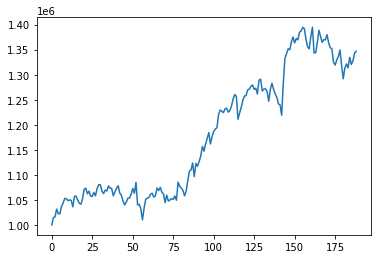

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.487141
Cumulative returns     0.346679
Annual volatility      0.195709
Sharpe ratio           2.137396
Calmar ratio           6.601665
Stability              0.876191
Max drawdown          -0.073791
Omega ratio            1.432618
Sortino ratio          3.319542
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.099014
Daily value at risk   -0.022997
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (189, 8)
Annual return          0.394235
Cumulative returns     0.283075
Annual volatility      0.154600
Sharpe ratio           2.239574
Calmar ratio           4.414337
Stability              0.899611
Max drawdown          -0.089308
Omega ratio            1.448302
Sortino ratio          3.363498
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078874
Daily value at risk   -0.018104
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (189, 8)


Start date,2020-07-08
End date,2021-04-08
Total months,9
,Backtest
Annual return,48.714%
Cumulative returns,34.668%
Annual volatility,19.571%
Sharpe ratio,2.14
Calmar ratio,6.60
Stability,0.88
Max drawdown,-7.379%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.38,2021-02-25,2021-03-25,NaT,NaN
1,6.91,2020-09-18,2020-09-24,2020-10-27,28
2,5.56,2021-01-11,2021-01-29,2021-02-02,17
3,3.92,2020-12-17,2020-12-21,2020-12-30,10
4,3.73,2020-08-18,2020-09-09,2020-09-18,24


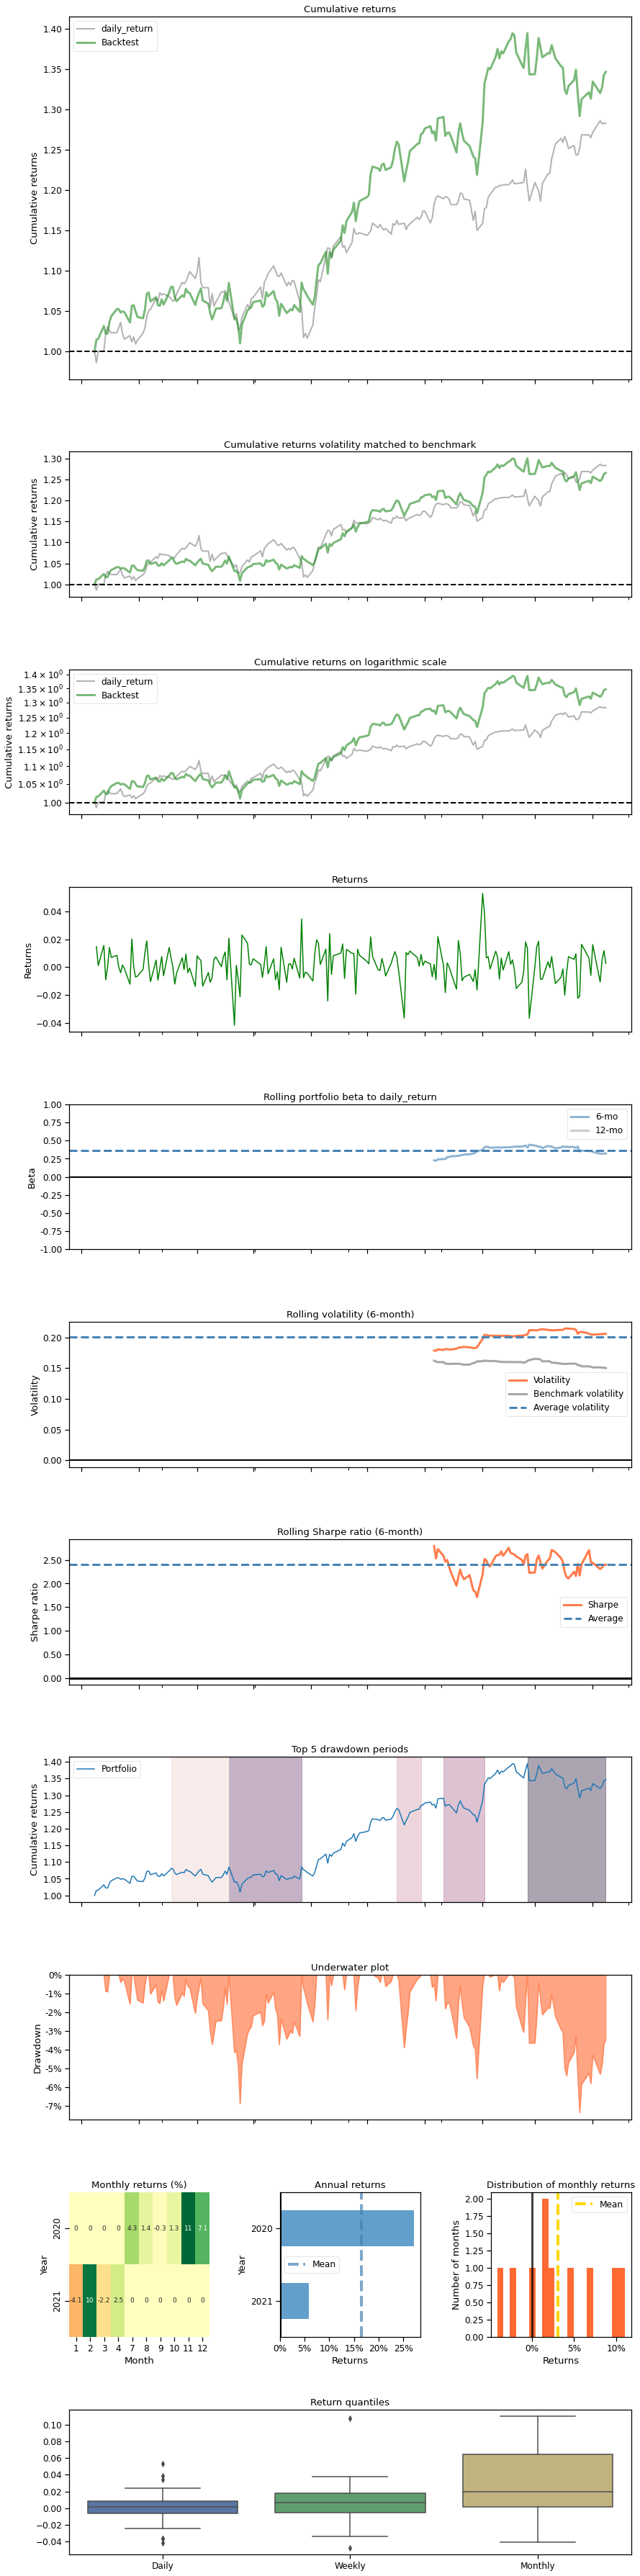

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])